# Laboratorio 3

- José Prince
- Diego Linares

En este laboratorio se trabajará con el dataset de Kaggle: https://www.kaggle.com/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/data. A continuación se muestra el contenido de los diferentes módulos que tiene el dataset a utilizar.


In [14]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pyfiglet
import tensorflow as tf
from tensorflow.keras import layers, models 
from collections import Counter
import numpy as np

            ___  
 _ __ ___  / _ \ 
| '_ ` _ \| | | |
| | | | | | |_| |
|_| |_| |_|\___/ 
                 



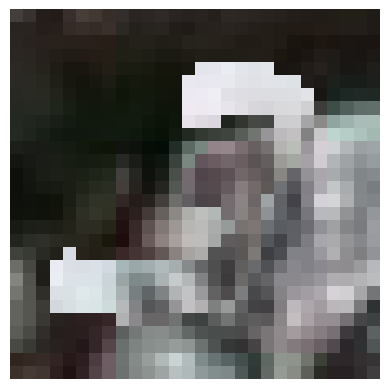

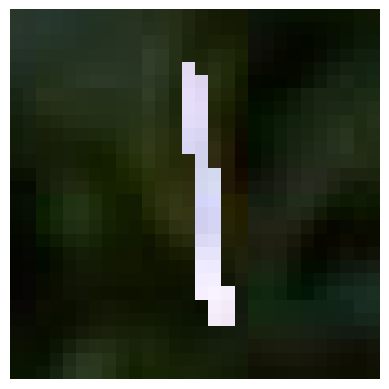

           _ 
 _ __ ___ / |
| '_ ` _ \| |
| | | | | | |
|_| |_| |_|_|
             



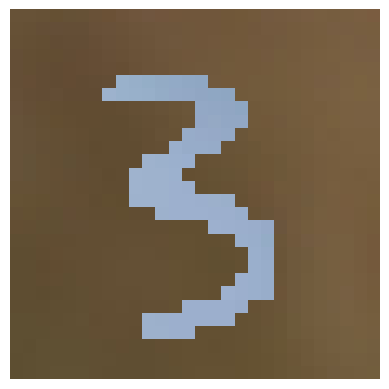

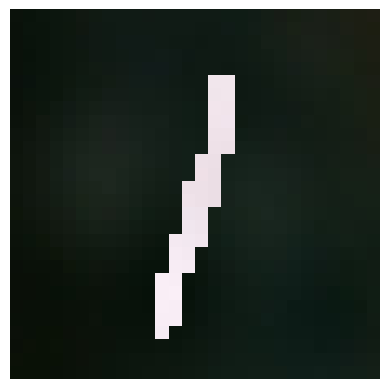

           ____  
 _ __ ___ |___ \ 
| '_ ` _ \  __) |
| | | | | |/ __/ 
|_| |_| |_|_____|
                 



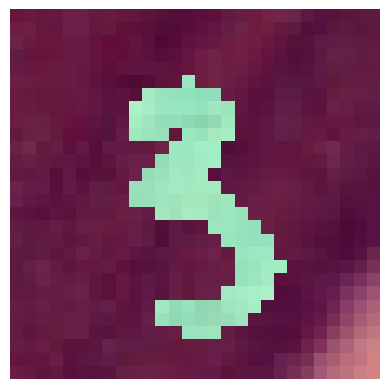

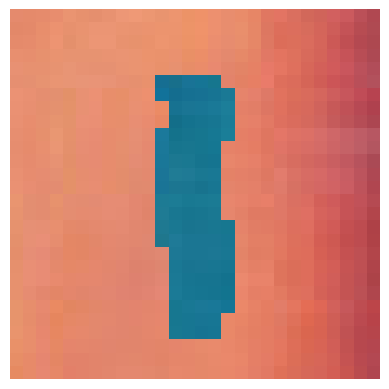

           _____ 
 _ __ ___ |___ / 
| '_ ` _ \  |_ \ 
| | | | | |___) |
|_| |_| |_|____/ 
                 



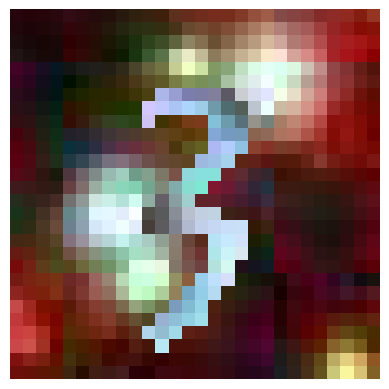

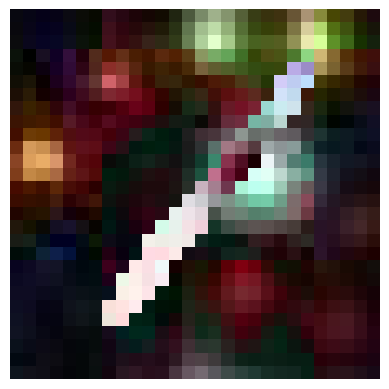

           _  _   
 _ __ ___ | || |  
| '_ ` _ \| || |_ 
| | | | | |__   _|
|_| |_| |_|  |_|  
                  



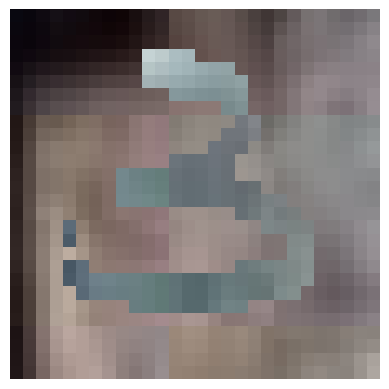

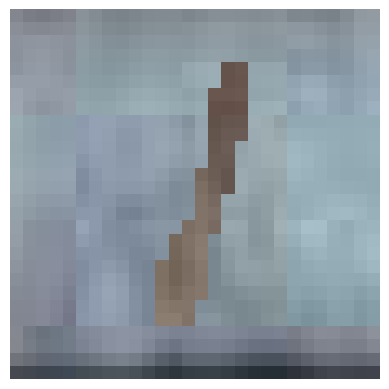

In [2]:
main_route = "./PolyMNIST/MMNIST/train/"

for i in range(5):
    module = "m" + str(i)
    route = main_route + module
    print(pyfiglet.figlet_format(module))
    if os.path.exists(route):
        images = [f for f in os.listdir(route) if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif"))]
        for img in images[:2]:
            img_route = os.path.join(route, img)
            try:
                image = Image.open(img_route)
                plt.imshow(image)
                plt.axis('off')
                plt.show()        
            except Exception as e:
                print(f"Error al cargar {img_route}: {e}")        

## Analisis exploratorio

Para el dataset que tenemos vamos a naalizar como estan distribuidas las diferentes clases e identificar si existe un desbalanceo. 

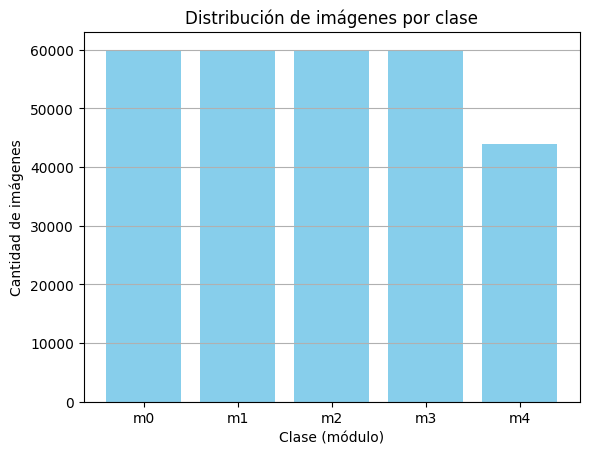

In [6]:
clases = sorted(os.listdir(main_route))

count = {}
for clase in clases:
    route = os.path.join(main_route, clase)
    if os.path.isdir(route):
        count[clase] = len([
            f for f in os.listdir(route)
            if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif"))
        ])

plt.bar(count.keys(), count.values(), color='skyblue')
plt.title("Distribución de imágenes por clase")
plt.xlabel("Clase (módulo)")
plt.ylabel("Cantidad de imágenes")
plt.grid(True, axis='y')
plt.show()

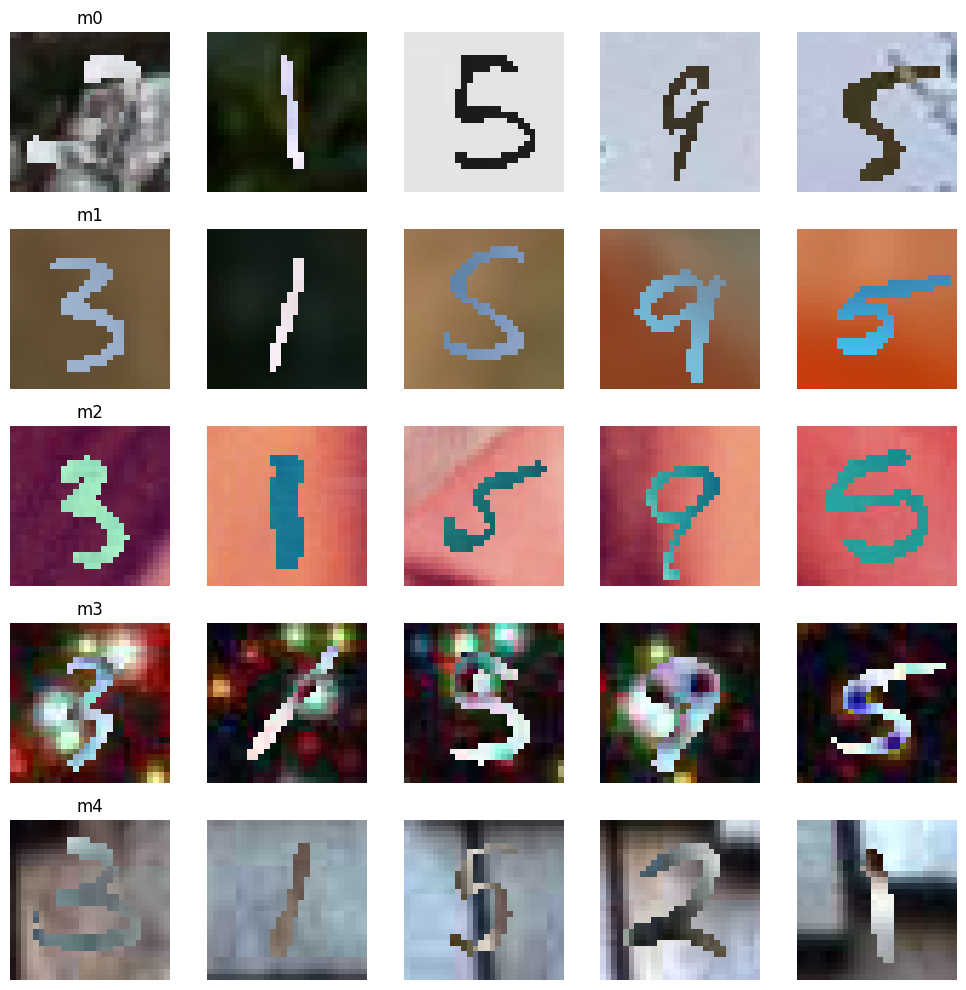

In [8]:

fig, axs = plt.subplots(len(clases), 5, figsize=(10, 10))
for i, clase in enumerate(clases):
    ruta_clase = os.path.join(main_route, clase)
    imagenes = [f for f in os.listdir(ruta_clase) if f.endswith((".png", ".jpg"))][:5]
    for j, imagen in enumerate(imagenes):
        ruta_img = os.path.join(ruta_clase, imagen)
        img = Image.open(ruta_img)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(clase)
plt.tight_layout()
plt.show()

In [11]:
dimensiones = []
for clase in clases:
    ruta_clase = os.path.join(main_route, clase)
    for archivo in os.listdir(ruta_clase):
        if archivo.lower().endswith((".png", ".jpg", ".jpeg")):
            ruta_img = os.path.join(ruta_clase, archivo)
            try:
                with Image.open(ruta_img) as img:
                    dimensiones.append(img.size)  # (ancho, alto)
            except:
                pass

conteo_dim = Counter(dimensiones)
print("Tamaños más comunes:")
for dim, count in conteo_dim.most_common(5):
    print(f"{dim}: {count} imágenes")

Tamaños más comunes:
(28, 28): 283961 imágenes


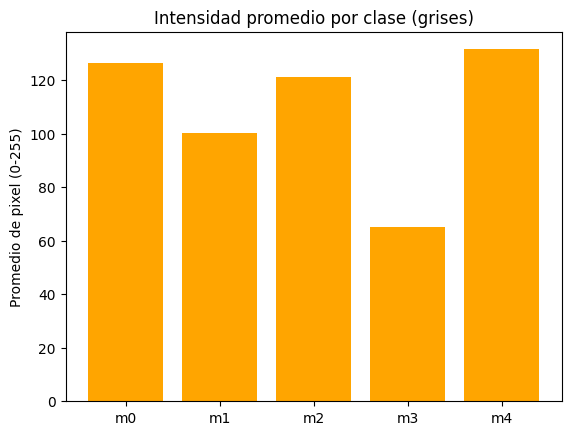

In [15]:
promedios = {}

for clase in clases:
    ruta_clase = os.path.join(main_route, clase)
    intensidades = []
    for archivo in os.listdir(ruta_clase)[:100]:  # Limita si tienes muchas
        ruta_img = os.path.join(ruta_clase, archivo)
        try:
            with Image.open(ruta_img) as img:
                img = img.convert("L")  # Escala de grises para intensidad
                intensidades.append(np.array(img).mean())
        except:
            pass
    promedios[clase] = np.mean(intensidades)

# Visualizar
plt.bar(promedios.keys(), promedios.values(), color='orange')
plt.title("Intensidad promedio por clase (grises)")
plt.ylabel("Promedio de pixel (0-255)")
plt.show()


## Modelos CNN

### Primer modelo

Para el primer modelo de CNN se implemento utilizando Keras, este modelo tiene como proposito clasificar imágenes RGB que representan dígitos. Este carga las imágenes desde los diferentes modulos que hay para el entrenamiento. Las imágenes son redimiensionadas a 28x28 píxeles y normalizadas para facilitar el entrenamiento. La arquitectura consta de dos capas convolucionales seguidas de capas de max-pooling para la extracción de características, una cap densa intermedia y una capa de salida con activación softmax que aisgna probabilidaddes a cada una de las clases.

In [3]:
train_dir = "./PolyMNIST/MMNIST/train/"
 
img_size = (28, 28)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    seed=42
)

val_ds = train_ds.take(100)
train_ds = train_ds.skip(100)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(28, 28, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

loss, acc = model.evaluate(val_ds)
print(f"\nPrecisión en validación: {acc * 100:.2f}%")

Found 283961 files belonging to 5 classes.
Epoch 1/5


E0000 00:00:1753993960.726378    2734 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1753993960.735284    2734 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/akice/Documents/Repositories/Lab3-DataScience/venv/lib/python3.13/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8774/8774 ━━━━━━━━━━━━━━━━━━━━ 119s 13ms/step - accuracy: 0.9656 - loss: 0.0868 - val_accuracy: 0.9894 - val_loss: 0.0272
Epoch 2/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 113s 13ms/step - accuracy: 0.9927 - loss: 0.0225 - val_accuracy: 0.9959 - val_loss: 0.0124
Epoch 3/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 114s 13ms/step - accuracy: 0.9958 - loss: 0.0129 - val_accuracy: 0.9962 - val_loss: 0.0064
Epoch 4/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 118s 13ms/step - accuracy: 0.9965 - loss: 0.0105 - val_accuracy: 0.9994 - val_loss: 0.0047
Epoch 5/5
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 116s 13ms/step - accuracy: 0.9971 - loss: 0.0093 - val_accuracy: 0.9966 - val_loss: 0.0143
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9972 - loss: 0.0128

Precisión en validación: 99.72%


### Segundo modelo



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dropout, Dense, BatchNormalization, InputLayer
)

img_size = (64, 64)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    seed=42
)


input_shape = (64, 64, 3)
num_classes = 10

model2 = Sequential()
model2.add(InputLayer(input_shape=input_shape))

model2.add(SeparableConv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(SeparableConv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))

model2.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.4))

model2.add(GlobalAveragePooling2D())

model2.add(Dense(num_classes, activation='softmax'))

model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Found 283961 files belonging to 5 classes.


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_12             │ (None, 64, 64, 32)     │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_13             │ (None, 32, 32, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_14             │ (None, 16, 16, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,637 (53.27 KB)

 Trainable params: 13,189 (51.52 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/5
 765/8874 ━━━━━━━━━━━━━━━━━━━━ 27:25 203ms/step - accuracy: 0.7996 - loss: 0.5724

## Modelo simple